<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W281_HW/blob/main/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Image Stitching

MIDS W281: Computer Vision

## Recommended Libraries

In [14]:
!mkdir align_images deliverable

mkdir: cannot create directory ‘align_images’: File exists
mkdir: cannot create directory ‘deliverable’: File exists


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from utils import *
import copy


![Hybrid Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_5/teaser.png)

 ### Overview
Remember in class you learned how to compute the homography between two planar surfaces. In this assignment, you will use that knowledge to stitch together the images of the above restaurant advertisement.

 ### Description
 There are two images inside the ***align_images*** directory. You will write Python code to perform the following.

 1. **Homography Computation:** Write a Python function that takes as input two images (source and destination image) and computes the homography from the source to the destination image. You can use the `findHomography` method in OpenCV. The homography calculation requires at least four point correspondences between the two images, which you can select manually. However, with only four points the homography recovery can be prone to noise, so feel free to select more than four point correspondences.
Establishing point correspondences is very important because an error of just a few pixels can produce large errors in the recovered homography. We have provided a set of four hard-coded point correspondences in the code, but you should also try to add more points and compute the homography with your own set of points. You can provide point matches with a mouse-clicking interface such as `ginput`. Display a plot showing the point-correspondences on the two images and print the computed homography.  

2. **Image Bounds:** As the final output image should be large enough to contain both the transformed source image and the destination image, we need to first compute the size of the final image. For this, you will use the corners of the source and destination images i.e `(0, 0, im.shape[1], im.shape[0])` to find the bounds for the final image. Warp the the source corners using the above homography, and combine with the destination corners to compute the final bounds. You can use the `perspectiveTransform` method from Python's OpenCV library to warp the source bounds.    
    ***Hint: The final image bounds can have negative values, which means that the source image, after warping, will lie above and/or left of the (0,0) position in the destination image.***

3. **Image Warping:** In order to stitch the `src` and `dest` images, you need to warp the `src` to the `dest` image first. You will do this warping using the `warp_image_with_bounds` provided to you in utils.py. The function expects the source image, homography, and the final image bounds computed above. The output of the function will be large enough to contain both source and destination images. However, the output image will contain only the source image warped to the destination space and translated so that the left-top of the output image is at (0,0) (remember the negative values in the image bounds).  

4. **Image-pair stitching:** Finally place the destination image into the final output. The output image has been translated so that the left-top of the output image is at (0,0). You will need to shift the destination image by the same amount before placing it in the output image. You can simply replace the pixel values of the output image with destination image (we are not doing any blending at the image seam).  

5. **Image rectification:** Finally, you will rectify the stitched image so that the windows become frontal-parallel. This is the same as was done in the class exercise, where you can assume that each of the two large windows is square. For this part, use the four corners of the window in the stitched image (see above figure) and transform it to the destination points given in the code. Select the points in the correct order. Finally, display and submit the rectified image. You can use the image warping code from above.  

### Deliverables:

- A plot displaying the selected point correspondences between the images
- The computed homography between the images (print the matrix)
- The output image after stitching
- The output image after rectification
- Python code for homography compuation, image stitching, and image rectification

(2553, 2632, 3) (2453, 2923, 3)


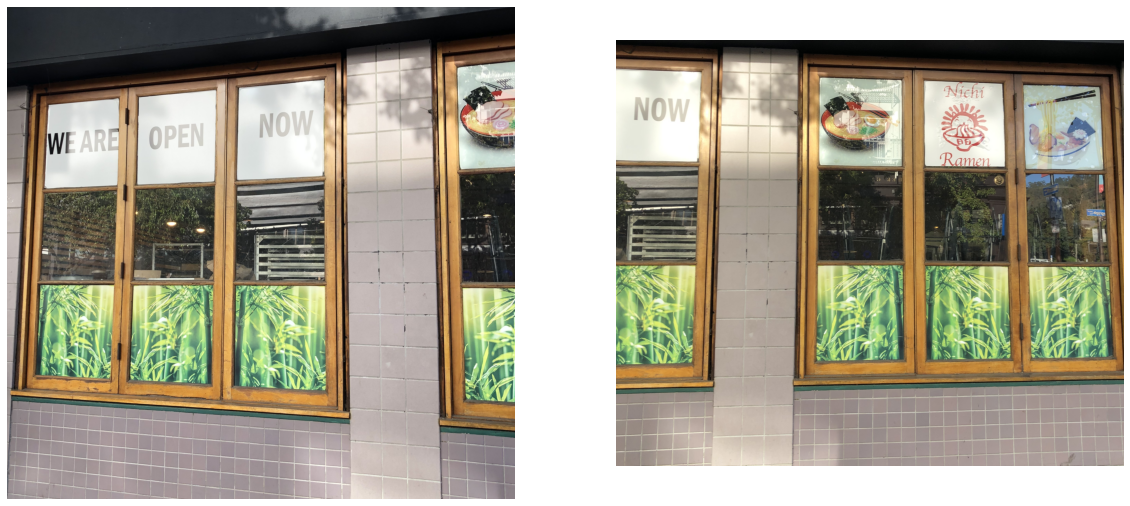

In [16]:
img_src_path = '/content/align_images/src.png'
img_dst_path = '/content/align_images/dest.png'
stitched_path = '/content/deliverable/stitched.png'
rectified_path = '/content/deliverable/rectified.png'

img_src = plt.imread(img_src_path)
img_dst = plt.imread(img_dst_path)
img_src = np.float32(img_src)
img_dst = np.float32(img_dst)

img_src_orig = copy.deepcopy(img_src)
img_dst_orig = copy.deepcopy(img_dst)

print(img_src.shape, img_dst.shape)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].imshow(img_src)
ax[0].axis('off')
ax[1].imshow(img_dst)
ax[1].axis('off')
plt.show()

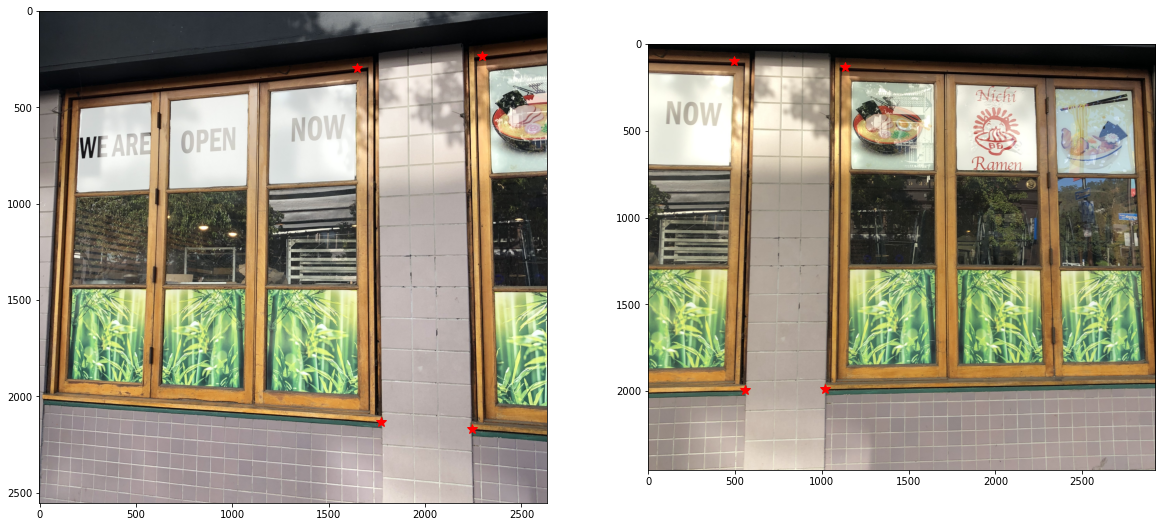

[[ 1.45375024e+00 -4.90632982e-02 -1.75080681e+03]
 [ 2.09599101e-01  1.32473502e+00 -6.12749672e+02]
 [ 1.68016949e-04 -8.99058221e-07  1.00000000e+00]]


<ipython-input-17-42489e13ad43>:47: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H = np.linalg.lstsq(A, b)[0]


In [17]:
# find the homography between the the src to destination image using the given points
# if you want you can add more point correspondences
def find_homography_manual(img_src_path, img_dst_path, img_src = None, img_dst = None, pts_src = None, pts_dst = None):
    
    if img_src is None:
        img_src = plt.imread(img_src_path)
        img_src = np.float32(img_src)
    
    if img_dst is None:
        img_dst = plt.imread(img_dst_path)
        img_dst = np.float32(img_dst)
    
    # get the points on the source image
    if pts_src is None:
        pts_src = np.array([[1649.15, 298], 
                            [2293.79, 236.60],
                            [2243.19, 2168.90],
                            [1770.98, 2133.52]])
    
    # get the points on the destination image
    if pts_dst is None:
        pts_dst = np.array([[495, 100], 
                            [1135, 131],
                            [1021, 1986],
                            [555,1995]])
    
    # visualize the points
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax[0].imshow(img_src)
    #ax[0].axis('off')
    ax[0].plot(pts_src[:,0], pts_src[:,1], 'r*', markersize=10)
    ax[1].imshow(img_dst)
    #ax[1].axis('off')
    ax[1].plot(pts_dst[:,0], pts_dst[:,1], 'r*', markersize=10)
    plt.show()
    
    # TODO: compute homography using the pts_src and pts_dst
    A = []
    b = []
    for i in range(len(pts_src)):
        src_x, src_y = pts_src[i]
        dst_x, dst_y = pts_dst[i]
        A.append([src_x, src_y, 1, 0, 0, 0, (-dst_x * src_x), (-dst_x * src_y)])
        A.append([0, 0, 0, src_x, src_y, 1, (-dst_y * src_x), (-dst_y * src_y)])
        b += [dst_x, dst_y]
    A = np.array(A)
    H = np.linalg.lstsq(A, b)[0]
    H = np.concatenate((H, [1]), axis=-1)
    print(np.reshape(H, (3, 3)))
    return np.reshape(H, (3, 3))

H = find_homography_manual(img_src_path, img_dst_path)

In [18]:
def stitch_images(img_src_path, img_dst_path):

    # read the images
    img_left = plt.imread(img_src_path)
    img_right = plt.imread(img_dst_path)
    img_left = img_left.astype(np.float32)
    img_right = img_right.astype(np.float32)

    # Convert to floating point image with intensity [0, 1]
    if np.max(img_left) > 1:
        img_left = img_left.astype(np.float32) / 255.0

    # Convert to floating point image with intensity [0, 1]
    if np.max(img_right) > 1:
        img_right = img_right.astype(np.float32) / 255.0
        
    pts_left = np.array([[1649.15, 298], 
                         [2293.79, 236.60], 
                         [2243.19, 2168.90], 
                         [1770.98, 2133.52]
                        ]
                      )
    pts_right = np.array([[495, 100], 
                          [1135, 131], 
                          [1021, 1986], 
                          [555,1995]
                         ]
                        )
    
    # Getting the dimension information of the left and right images
    left_img_height, left_img_width = img_left.shape[:2]
    right_img_height, right_img_width = img_right.shape[:2]

    # Calculating homography based on left and right points given
    # we can derive them by feature tracking.
    H = find_homography_manual(img_src_path, 
                               img_dst_path, 
                               img_left, 
                               img_right, 
                               pts_left, 
                               pts_right)
    
    # Getting the corner points of left and right images
    left_corner_pts = np.float32([ [0, 0], 
                                   [0, left_img_height - 1],
                                   [left_img_width - 1, left_img_height - 1], 
                                   [left_img_width - 1, 0]
                                 ]
                                ).reshape(-1,1,2)
    right_corner_pts = np.float32([ [0, 0], 
                                    [0, right_img_height - 1],
                                    [right_img_width - 1, right_img_height - 1], 
                                    [right_img_width - 1, 0]
                                  ]
                                 ).reshape(-1,1,2)

    # TODO: find the bounds of the stitched image
    # hint, use cv2.perspectiveTransform to help you
    # get the points on the source image
    # Calculating the perspective projection for left image
    # based on the homography matrix
    left_perspective_transform = cv2.perspectiveTransform(left_corner_pts, H)

    # Creating the combined list of corner points
    final_list_of_corner_points = np.concatenate((left_perspective_transform, 
                                                  right_corner_pts
                                                 ), 
                                                 axis=0
                                                )

    # TODO replace this with your calculations for the bounds
    # Getting one set of min and max x-value and y-value from two sets, 
    # pertaining to two images
    [x_min, y_min] = np.int32(final_list_of_corner_points.min(axis=0).ravel())
    [x_max, y_max] = np.int32(final_list_of_corner_points.max(axis=0).ravel())

    [xmin, ymin, xmax, ymax] = [x_min, y_min, x_max, y_max]
    
    # warp the image with bounds
    # Warping on the left image is only required as the right image is the
    # reference image.
    # warp_image_with_bounds will handle the translation of the image
    #  [xmin, ymin, xmax, ymax] will create a big image to accomodate
    # both left and right images in the single canvas.
    # The below step will put the warped left image on the left side of the canvas.
    result = warp_image_with_bounds(img_src, H, [xmin, ymin, xmax, ymax])
    
    # TODO: put the dest image in the result
    # The below step will handle the translation of the right image 
    # in the appropriate position.
    # To  align right and left image, we need to move down y axis by y_min
    # and move right by x_min.
    result[abs(y_min) - 1 : abs(y_min) + img_right.shape[0] - 1,
           abs(x_min) - 1 : abs(x_min) + img_right.shape[1] - 1
          ] = img_right

    # visualize the result
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    ax.imshow(result)
    ax.axis('off')
    
    return result

In [19]:
def rectify(img_src_path):
    
    # mark the 4 points on the window
    pts_src = np.array([[464.48358, 727.9149 ], 
                     [2370.2458, 796.1351 ],
                     [2310.8284, 2484.0332 ],
                     [277.4284, 2525.8455 ]]).astype(np.float32)
    pts_dst = np.array([[0, 0], 
                        [2000, 0], 
                        [2000, 2000], 
                        [0, 2000]]).astype(np.float32)
    img_src = plt.imread(img_src_path)
    
    #TODO: compute homography using pts_src and pts_dst using the cv2.findHomography method
    H = cv2.findHomography(pts_src, pts_dst)
    
    # TODO: compute the bounds of the output rectified image
    # hint, use cv2.perspectiveTransform to help you
    perspective_transform = cv2.perspectiveTransform(img_src, H[0])
    
    #TODO: replace this with your calculations for the bounds
    [x_min, y_min] = np.int32(perspective_transform.min(axis=0).ravel())
    [x_max, y_max] = np.int32(perspective_transform.max(axis=0).ravel())
    [xmin, ymin, xmax, ymax] = [x_min, y_min, x_max, y_max]
    
    # warp the image using the bounds
    result = warp_image_with_bounds(img_src, H, [x_min, y_min, x_max, y_max])
    
    # visualize the result
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    ax.imshow(result)
    ax.axis('off')
    
    return result    

In [ ]:
# TODO: complete the code for image stitching
out = stitch_images(img_src_path, img_dst_path)
plt.imsave(stitched_path, out)


# TODO: complete the code for image rectification
rect = rectify(stitched_path)
plt.imsave(rectified_path, rect)
